In [105]:
import goes_ortho

In [106]:
# Ground position
lon_deg = -119  # longitude of ground point in degrees
lat_deg = 37  # latitude of ground point in degrees
z = 3000  # height of ground point above ellispoid in meters

# GRS 80 ellipsoid parameters
req = 6378137.0  # semi-major axis (equatorial radius) in meters
rpol = 6356752.31414  # semi-minor axis (polar radius) in meters
e = 0.0818191910435  # eccentricity (plane through poles)

# Satellite position
H = 42164160.0  # satellite height from center of ellipsoid in meters
lon_0_deg = (
    -75.2
)  # sub-satellite point longitude in degrees (assumes sub-satellite latitude = 0)

In [107]:
# Original projection (no orthorectification)
x_original, y_original = goes_ortho.LonLat2ABIangle(
    lon_deg, lat_deg, 0, H, req, rpol, e, lon_0_deg
)
# Project back onto lat/lon map
lon_original, lat_original = goes_ortho.ABIangle2LonLat(
    x_original, y_original, H, req, rpol, lon_0_deg
)

# Taking height above ellispoid into account (orthorectification)
x_ortho, y_ortho = goes_ortho.LonLat2ABIangle(
    lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg
)
# Project back onto lat/lon map
lon_ortho, lat_ortho = goes_ortho.ABIangle2LonLat(
    x_ortho, y_ortho, H, req, rpol, lon_0_deg
)

In [108]:
print(x_original, y_original)
print(x_ortho, y_ortho)
print("\n")
print(lon_original, lat_original)
print(lon_ortho, lat_ortho)

-0.09102619927785786 0.09887293213489763
-0.0910724535008453 0.0989236178278887


-119.0 36.99999999999999
-119.05492120066657 37.027503742516735


Calculate distance, spherical approximation:

In [112]:
def great_circle(lon1, lat1, lon2, lat2):
    # https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dist = 6371 * np.arccos(
        np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)
    )
    return dist


def haversine(lon1, lat1, lon2, lat2):
    # https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    dist = 2 * 6371 * np.arcsin(np.sqrt(a))
    return dist

In [113]:
great_circle(lon_original, lat_original, lon_ortho, lat_ortho)

5.756028361927186

In [114]:
haversine(lon_original, lat_original, lon_ortho, lat_ortho)

5.756028361435808

---

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [27]:
dem = xr.open_rasterio("GMTED2010_W_1deg_mean.tif")

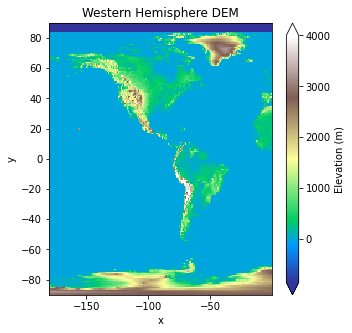

In [28]:
plt.figure(figsize=(5, 5))
dem.plot(
    vmin=-850,
    vmax=4000,
    cmap="terrain",
    zorder=0,
    cbar_kwargs={"label": "Elevation (m)"},
)
plt.title("Western Hemisphere DEM");

In [62]:
x, y = np.meshgrid(dem.x, dem.y)

In [63]:
dem0 = xr.DataArray(
    np.zeros_like(dem),
    coords={"band": dem.band, "x": dem.x, "y": dem.y},
    dims=("band", "x", "y"),
)

[abi_grid_x0, abi_grid_y0] = goes_ortho.LonLat2ABIangle(
    x, y, np.zeros_like(dem.values.squeeze()), H, req, rpol, e, lon_0_deg
)

In [64]:
[abi_grid_x, abi_grid_y] = goes_ortho.LonLat2ABIangle(
    x, y, dem.values.squeeze(), H, req, rpol, e, lon_0_deg
)

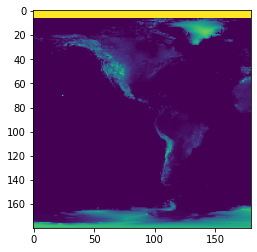

In [78]:
plt.imshow(
    np.sqrt((abi_grid_x0 - abi_grid_x) ** 2 + (abi_grid_y0 - abi_grid_y) ** 2),
    vmin=0,
    vmax=0.0001,
)

In [135]:
lon_original, lat_original = goes_ortho.ABIangle2LonLat(
    abi_grid_x0, abi_grid_y0, H, req, rpol, lon_0_deg
)
lon_ortho, lat_ortho = goes_ortho.ABIangle2LonLat(
    abi_grid_x, abi_grid_y, H, req, rpol, lon_0_deg
)
dist = haversine(lon_original, lat_original, lon_ortho, lat_ortho)

/home/spestana/git/goes-ortho/goes_ortho.py:30: RuntimeWarning: invalid value encountered in sqrt
  rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arcsin
  del sys.path[0]


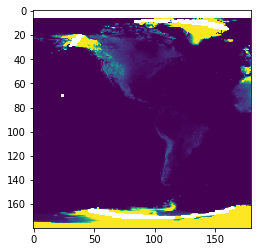

In [138]:
plt.imshow(dist, vmin=0, vmax=10)

(0.0, 6.0)

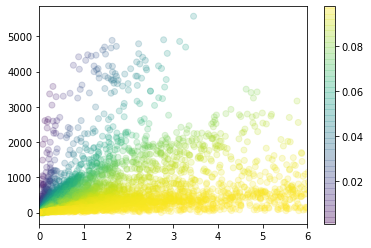

In [142]:
_colors = np.sqrt(abi_grid_x**2 + abi_grid_y**2)
colors = _colors / np.max(_colors)
plt.scatter(dist.ravel(), dem.values.squeeze().ravel(), c=colors, alpha=0.2)
plt.colorbar()
plt.xlim(0, 6)